# kmeans 量化实践

聚类量化是利用K-means方法得到权重的聚类中心和标签。同时根据聚类中心和标签又可以回推到weight，当然过程中有损失。
<div align="center"> <img src="../images/k-means.png"> </div>

## 环境配置

首先，我们安装必须的环境，数据集和model使用和前几章相同的minist数据集和LeNet网络。

加载用到的python库

In [1]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
import torch.nn.functional as F
from torchvision import datasets


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## 构建模型和数据集

数据集和模型的链接如下：

- 模型权重：https://github.com/datawhalechina/awesome-compression/blob/main/docs/notebook/ch02/model.pt
- 数据集：https://github.com/datawhalechina/awesome-compression/tree/main/docs/notebook/ch02/data/mnist/MNIST/raw

创建模型

In [2]:
# 定义一个LeNet网络
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))

        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu") # 默认使用CPU
model = LeNet().to(device=device)

数据加载

In [3]:
# 设置归一化
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# 获取数据集
data_dir = "../../01prune/notebook/0.minist_classify"
train_dataset = datasets.MNIST(root=data_dir+'/data/mnist', train=True, download=True, transform=transform)  
test_dataset = datasets.MNIST(root=data_dir+'/data/mnist', train=False, download=True, transform=transform)  # train=True训练集，=False测试集

# 设置DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

加载预训练模型

In [4]:
# 加载模型的状态字典
checkpoint = torch.load(data_dir+'/model.pt')
# 加载状态字典到模型
model.load_state_dict(checkpoint)
fp32_model = copy.deepcopy(model)

/tmp/ipykernel_1364/2689321200.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(data_dir+'/model.pt')


## 构建训练和验证函数

In [5]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    # inputs = inputs.to('mps')
    # targets = targets.to('mps')

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [6]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  extra_preprocess = None
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
    # Move the data from CPU to GPU
    # inputs = inputs.to('mps')
    if extra_preprocess is not None:
        for preprocess in extra_preprocess:
            inputs = preprocess(inputs)

    # targets = targets.to('mps')

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

## 创建两个函数：计算 Flops 和 Model Size

- 参数量（ params ）：
    参数的数量，通常以M为单位。
    params = Kh × Kw × Cin × Cout
- 模型大小(模型大小)：
    在一般的深度学习的框架中（如 PyTorch ），一般是 32 位存储，即一个参数用 32 个 bit 来存储。所以，一个拥有 1M（这里的M是数量单位一百万）参数量的模型所需要的存储空间大小为：1M * 32bit = 32Mb = 4MB。
- 计算量( Flops )：

    即浮点运算数，用来衡量算法/模型的复杂度。图通常只考虑乘加操作的数量，而且只考虑Conv和FC等参数层计算量，忽略BN和PReLU等。一般情况下，Conv和FC层也会忽略仅纯加操作的计算量，如偏置加和shortcut残差加等。目前技术只有BN和CNN可以不加偏置。
    FLOPs = Kh * Kw * Cin * Cout * H * W

In [7]:
def get_model_flops(model, inputs):
    num_macs = profile_macs(model, inputs)
    return num_macs

def get_model_size(model: nn.Module, data_width=32):
    """
    calculate the model size in bits
    :param data_width: #bits per element
    """
    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()
    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

## 验证 FP32 模型的精度以及模型大小

In [8]:
fp32_model_accuracy = evaluate(fp32_model, test_loader)
fp32_model_size = get_model_size(fp32_model)
print(f"fp32 model has accuracy={fp32_model_accuracy:.2f}%")
print(f"fp32 model has size={fp32_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/157 [00:00<?, ?it/s]

fp32 model has accuracy=97.99%
fp32 model has size=0.17 MiB


## 构建 K-means 量化函数

$n$比特的k-means量化将把数据划分为$2^n$个聚类，而相同聚类中的数据将共享相同的权重值。

k-means量化将创建一个 codebook ，其中包括：

- centroids：$2^n$ 个FP32聚类中心。
- labels：一个$n$比特的整数张量，与原始的FP32权重张量具有相同的元素数量。每个整数表示它属于哪个聚类。

在推理期间，基于 codebook 生成一个 FP32 张量进行推理：
> ***quantized_weight* = *codebook.centroids*\[*codebook.labels*\].view_as(weight)**

    target bitwidth: 2 bits
        num unique values before k-means quantization: 15
        num unique values after  k-means quantization: 4


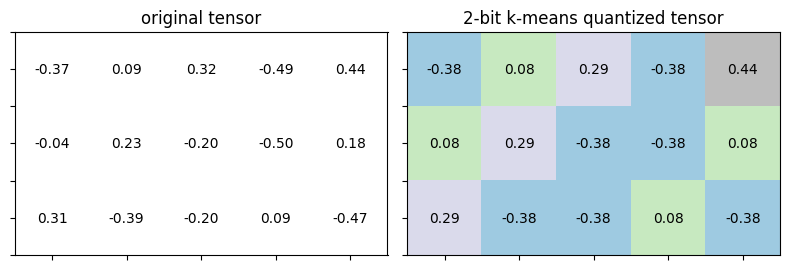

In [10]:
from fast_pytorch_kmeans import KMeans
from collections import namedtuple
import pdb
Codebook = namedtuple('Codebook', ['centroids', 'labels'])
def k_means_quantize(fp32_tensor: torch.Tensor, bitwidth=4, codebook=None):
    """
    quantize tensor using k-means clustering
    :param fp32_tensor:
    :param bitwidth: [int] quantization bit width, default=4
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    :return:
        [Codebook = (centroids, labels)]
            centroids: [torch.(cuda.)FloatTensor] the cluster centroids
            labels: [torch.(cuda.)LongTensor] cluster label tensor
    """
    if codebook is None:
        # 首先计算聚类的中心点个数
        # get number of clusters based on the quantization precision
        n_clusters = 2**bitwidth
        # print(n_clusters)
        # 用kmeans算法得到聚类的中心
        # use k-means to get the quantization centroids
        kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)
        labels = kmeans.fit_predict(fp32_tensor.view(-1, 1)).to(torch.long)
        centroids = kmeans.centroids.to(torch.float).view(-1)
        codebook = Codebook(centroids, labels)
    
    # decode the codebook into k-means quantized tensor for inference
    # 解码codebook，得到k-means量化后的tensor
    quantized_tensor = codebook.centroids[codebook.labels]
    
    fp32_tensor.set_(quantized_tensor.view_as(fp32_tensor))
    return codebook

def plot_matrix(tensor, ax, title, cmap=ListedColormap(['white'])):
    ax.imshow(tensor.cpu().numpy(), vmin=-0.5, vmax=0.5, cmap=cmap)
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    for i in range(0,tensor.shape[0]):
        for j in range(0,tensor.shape[1]):
            
            text = ax.text(j, i, f'{tensor[i, j].item():.2f}',ha="center", va="center", color="k") 
 
if __name__ == "__main__":
    bitwidth = 2
    test_tensor = torch.tensor([
        [-0.3747,  0.0874,  0.3200, -0.4868,  0.4404],
        [-0.0402,  0.2322, -0.2024, -0.4986,  0.1814],
        [ 0.3102, -0.3942, -0.2030,  0.0883, -0.4741]])
    
    fig, axes = plt.subplots(1,2, figsize=(8, 12))
    ax_left, ax_right = axes.ravel()
    
    plot_matrix(test_tensor, ax_left, 'original tensor')
    
    num_unique_values_before_quantization = test_tensor.unique().numel()

    codebook_test = k_means_quantize(fp32_tensor=test_tensor, bitwidth=bitwidth)
    # pdb.set_trace()
    num_unique_values_after_quantization = test_tensor.unique().numel()
    
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        num unique values before k-means quantization: {num_unique_values_before_quantization}')
    print(f'        num unique values after  k-means quantization: {num_unique_values_after_quantization}')
    assert num_unique_values_after_quantization == min((1 << bitwidth), num_unique_values_before_quantization)
    
    plot_matrix(test_tensor, ax_right, f'{bitwidth}-bit k-means quantized tensor', \
                    cmap='tab20c')
    fig.tight_layout()
    plt.show()

## 在FP32模型上进行K-means量化

在下边代码中构建的类`KMeansQuantizer`中，我们必须记录`centroids`和`labels`，以便在模型权重改变时应用或更新 `codebooks`。
    
``````

In [11]:
from torch.nn import parameter
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = self.quantize(model, bitwidth)

    @torch.no_grad()
    def apply(self, model, update_centroids):
        for name, param in model.named_parameters():
            if name in self.codebook:
                if update_centroids:
                    self.update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])
                
    def update_codebook(self,fp32_tensor: torch.Tensor, codebook: Codebook):
        """
        update the centroids in the codebook using updated fp32_tensor
        :param fp32_tensor: [torch.(cuda.)Tensor]
        :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
        """
        n_clusters = codebook.centroids.numel()
        fp32_tensor = fp32_tensor.view(-1)
        for k in range(n_clusters):
            cluster_points = fp32_tensor[codebook.labels == k]
            if cluster_points.numel() > 0:
                codebook.centroids[k] = cluster_points.mean()
                
    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook


接下来我们看一下不同的bitwidth下，模型量化后的精度和大小。

In [12]:
print('Note that the storage for codebooks is ignored when calculating the model size.')
quantizers = dict()
for bitwidth in [8, 4, 2]:
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(model, bitwidth)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, test_loader)
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer

Note that the storage for codebooks is ignored when calculating the model size.
k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=0.04 MiB


eval:   0%|          | 0/157 [00:00<?, ?it/s]

    8-bit k-means quantized model has accuracy=97.84%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=0.02 MiB


eval:   0%|          | 0/157 [00:00<?, ?it/s]

    4-bit k-means quantized model has accuracy=97.03%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=0.01 MiB


eval:   0%|          | 0/157 [00:00<?, ?it/s]

    2-bit k-means quantized model has accuracy=89.44%


## 训练 kmeans 量化模型
可以看到上一步中量化后的模型精度大幅下降，因此我们必须执行量化感知训练来恢复精度。

centroids的梯度更新公式如下：

> $\frac{\partial \mathcal{L} }{\partial C_k} = \sum_{j} \frac{\partial \mathcal{L} }{\partial W_{j}} \frac{\partial W_{j} }{\partial C_k} = \sum_{j} \frac{\partial \mathcal{L} }{\partial W_{j}} \mathbf{1}(I_{j}=k)$

 $\mathcal{L}$ 是损失, $C_k$ 是第 *k* 个 centroids , $I_{j}$ 是权重 $W_{j}$ 的 label 。$\mathbf{1}()$ 是找对应 label 的函数, 即, $I_{j}==k$.

我们用如下公式更新centroids：

> $C_k = \frac{\sum_{j}W_{j}\mathbf{1}(I_{j}=k)}{\sum_{j}\mathbf{1}(I_{j}=k)}$

In [13]:
accuracy_drop_threshold = 0.5
quantizers_before_finetune = copy.deepcopy(quantizers)
quantizers_after_finetune = quantizers

for bitwidth in [8, 4, 2]:
    quantizer = quantizers[bitwidth]
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer.apply(model, update_centroids=False)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, test_loader)
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}% before quantization-aware training ")
    accuracy_drop = fp32_model_accuracy - quantized_model_accuracy
    if accuracy_drop > accuracy_drop_threshold:
        print(f"        Quantization-aware training due to accuracy drop={accuracy_drop:.2f}% is larger than threshold={accuracy_drop_threshold:.2f}%")
        num_finetune_epochs = 10
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
        criterion = nn.CrossEntropyLoss()
        best_accuracy = 0
        epoch = num_finetune_epochs
        while accuracy_drop > accuracy_drop_threshold and epoch > 0:
            train(model, train_loader, criterion, optimizer, scheduler,
                  callbacks=[lambda: quantizer.apply(model, update_centroids=True)])
            model_accuracy = evaluate(model, test_loader)
            is_best = model_accuracy > best_accuracy
            best_accuracy = max(model_accuracy, best_accuracy)
            print(f'        Epoch {num_finetune_epochs-epoch} Accuracy {model_accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')
            accuracy_drop = fp32_model_accuracy - best_accuracy
            epoch -= 1
    else:
        print(f"        No need for quantization-aware training since accuracy drop={accuracy_drop:.2f}% is smaller than threshold={accuracy_drop_threshold:.2f}%")

k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=0.04 MiB


eval:   0%|          | 0/157 [00:00<?, ?it/s]

    8-bit k-means quantized model has accuracy=97.84% before quantization-aware training 
        No need for quantization-aware training since accuracy drop=0.15% is smaller than threshold=0.50%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=0.02 MiB


eval:   0%|          | 0/157 [00:00<?, ?it/s]

    4-bit k-means quantized model has accuracy=97.03% before quantization-aware training 
        Quantization-aware training due to accuracy drop=0.96% is larger than threshold=0.50%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

        Epoch 0 Accuracy 97.85% / Best Accuracy: 97.85%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=0.01 MiB


eval:   0%|          | 0/157 [00:00<?, ?it/s]

    2-bit k-means quantized model has accuracy=90.54% before quantization-aware training 
        Quantization-aware training due to accuracy drop=7.45% is larger than threshold=0.50%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

        Epoch 0 Accuracy 95.98% / Best Accuracy: 95.98%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

        Epoch 1 Accuracy 96.48% / Best Accuracy: 96.48%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

        Epoch 2 Accuracy 96.63% / Best Accuracy: 96.63%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

        Epoch 3 Accuracy 96.66% / Best Accuracy: 96.66%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

        Epoch 4 Accuracy 96.73% / Best Accuracy: 96.73%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

        Epoch 5 Accuracy 96.68% / Best Accuracy: 96.73%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

        Epoch 6 Accuracy 96.93% / Best Accuracy: 96.93%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

        Epoch 7 Accuracy 96.80% / Best Accuracy: 96.93%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

        Epoch 8 Accuracy 96.99% / Best Accuracy: 96.99%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

        Epoch 9 Accuracy 97.07% / Best Accuracy: 97.07%
